In [49]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn import preprocessing
import torch 
import torch.nn as nn

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [75]:
train_data = pd.read_csv('../datasets/spaceship_titanic/spaceship_train.csv')
test_data = pd.read_csv('../datasets/spaceship_titanic/spaceship_test.csv')

train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [76]:
train_data.describe().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [77]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [78]:
all_data = pd.concat([train_data, test_data])
all_data['Transported'] = all_data['Transported'].fillna('None')

test_ids = test_data['PassengerId'][:]

In [79]:
all_data.shape, train_data.shape, test_data.shape

((12970, 14), (8693, 14), (4277, 13))

In [80]:
feature_to_normalize = [feach for feach \
                        in all_data.columns\
                        if (all_data[feach].dtype != 'O') and (feach not in ['Age', 'Transported'])]

feature_to_normalize

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [81]:

def impute_miss_values(data):
    
    for col in data.columns:
        if data[col].dtype == 'O':
            data[col] = data[col].fillna('None')
        
        if data[col].dtype != 'O':
            data[col] = data[col].fillna(0)
        
    return data
        
        
all_data = impute_miss_values(all_data)

In [82]:
def impute_miss_object(x):
    if x == 'None':
        return 0
    else:
        return int(x)
    
        
all_data['Transported'] = all_data['Transported'].apply(impute_miss_object)
all_data['CryoSleep'] = all_data['CryoSleep'].apply(impute_miss_object)
all_data['VIP'] = all_data['VIP'].apply(impute_miss_object)

In [83]:
all_data['starboard'] = all_data['Cabin'].apply(lambda x: x[-1])
all_data['deck'] = all_data['Cabin'].apply(lambda x: x[0])

all_data['group'] = all_data['PassengerId'].apply(lambda x: int(x[:4]))


In [84]:
all_data['group'] = all_data['PassengerId'].apply(lambda x: int(x[:4]))

In [85]:
all_data.isna().sum().sum(), test_data.isna().sum().sum()

(0, 1117)

In [86]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  int64  
 3   Cabin         12970 non-null  object 
 4   Destination   12970 non-null  object 
 5   Age           12970 non-null  float64
 6   VIP           12970 non-null  int64  
 7   RoomService   12970 non-null  float64
 8   FoodCourt     12970 non-null  float64
 9   ShoppingMall  12970 non-null  float64
 10  Spa           12970 non-null  float64
 11  VRDeck        12970 non-null  float64
 12  Name          12970 non-null  object 
 13  Transported   12970 non-null  int64  
 14  starboard     12970 non-null  object 
 15  deck          12970 non-null  object 
 16  group         12970 non-null  int64  
dtypes: float64(6), int64(4), object(7)
memory usage: 1.8+ MB


In [87]:
all_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,starboard,deck,group
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,P,B,1
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,S,F,2
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,S,A,3
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,S,A,3
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,S,F,4


In [88]:
all_data.drop(['Cabin','Name', 'PassengerId'], axis=1, inplace=True)

In [89]:
all_data[feature_to_normalize]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...
4272,0.0,0.0,0.0,0.0,0.0
4273,0.0,847.0,17.0,10.0,144.0
4274,0.0,0.0,0.0,0.0,0.0
4275,0.0,2680.0,0.0,0.0,523.0


<AxesSubplot: >

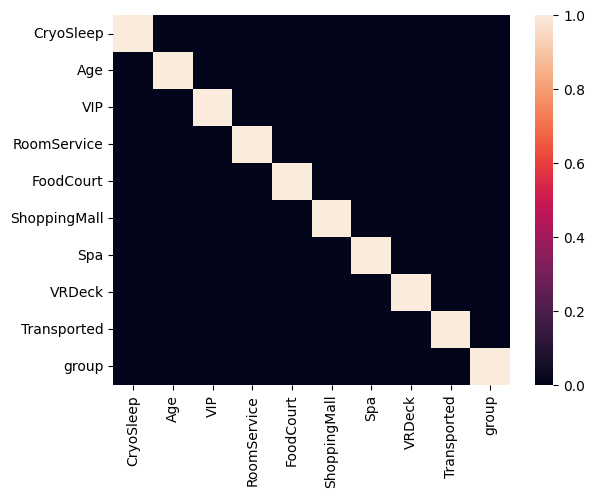

In [90]:
sns.heatmap(all_data.corr() > 0.5)

In [91]:
scalar = preprocessing.MinMaxScaler()

all_data[feature_to_normalize] = scalar.fit_transform(all_data[feature_to_normalize]).round(3)

In [92]:
all_data.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,group
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,0.353200,28.173015,0.021049,0.015238,0.014817,0.007261,0.013458,0.012442,0.337548,4635.337471
std,0.477983,14.817542,0.143552,0.044796,0.052598,0.024867,0.049929,0.048433,0.472892,2685.904299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2306.250000
50%,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4632.000000
75%,1.000000,37.000000,0.000000,0.003000,0.002000,0.001000,0.002000,0.001000,1.000000,6924.750000
max,1.000000,79.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9280.000000


In [93]:
for col in all_data.columns:
    if all_data[col].dtype == 'O':
        print(col,len(all_data[col].unique()))

HomePlanet 4
Destination 4
starboard 3
deck 9


In [94]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int64  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Transported   12970 non-null  int64  
 11  starboard     12970 non-null  object 
 12  deck          12970 non-null  object 
 13  group         12970 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 1.5+ MB


In [95]:

all_data = pd.get_dummies(all_data)

In [96]:
all_data.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,group,...,starboard_e,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_N,deck_T
0,0,39.0,0,0.000,0.000,0.000,0.000,0.000,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,24.0,0,0.008,0.000,0.001,0.025,0.002,1,2,...,0,0,0,0,0,0,1,0,0,0
2,0,58.0,1,0.003,0.120,0.000,0.300,0.002,0,3,...,0,1,0,0,0,0,0,0,0,0
3,0,33.0,0,0.000,0.043,0.016,0.149,0.008,0,3,...,0,1,0,0,0,0,0,0,0,0
4,0,16.0,0,0.021,0.002,0.006,0.025,0.000,1,4,...,0,0,0,0,0,0,1,0,0,0


In [97]:

train_shape = train_data.shape[0] - 1500
n = 1500

train_data = all_data[:train_shape].copy()

valid_data = all_data[train_shape:train_shape +n].copy()

test_data = all_data[train_shape + n:].copy()

X_train = train_data.drop('Transported', axis=1).values
X_valid = valid_data.drop('Transported', axis=1).values

y_train = train_data['Transported'].copy()
y_valid = valid_data['Transported'].copy()


train_data.shape[0], valid_data.shape[0], test_data.shape[0]

(7193, 1500, 4277)

In [98]:
X_test = test_data.values

In [99]:
y_train.shape[0], y_valid.shape[0]

(7193, 1500)

In [100]:
train_data['Transported'].value_counts()

1    3677
0    3516
Name: Transported, dtype: int64

In [101]:
X_valid.shape

(1500, 29)

### Random forest

In [117]:
fores_clf = RandomForestClassifier(n_estimators=500,random_state=17)

params = {'max_depth': [2,3,4,6,7]}

grid_forest = GridSearchCV(fores_clf,params, n_jobs=-1, cv=5)

In [118]:
grid_forest.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=500,
                                              random_state=17),
             n_jobs=-1, param_grid={'max_depth': [2, 3, 4, 6, 7]})

In [120]:
grid_forest.best_params_

{'max_depth': 7}

In [121]:
best_forest = grid_forest.best_estimator_
pred_f = best_forest.predict(X_valid)


In [122]:

print(f"Accuracy : {accuracy_score(y_valid,pred_f)}")
print(f"ROC AUC : {roc_auc_score(y_valid,pred_f)}")
print(f"Precision : {precision_score(y_valid,pred_f)}")
print(f"Recall : {recall_score(y_valid,pred_f)}")

Accuracy : 0.7946666666666666
ROC AUC : 0.7964984761622498
Precision : 0.7575360419397117
Recall : 0.8245363766048502


### Logistic regression

In [40]:
log_clf = LogisticRegression(n_jobs=-1,random_state=17)

params_log = {
    'C': [0.5, 1,1.5,2,3,4],
    'max_iter': [60,80,100,120,140]
}

grid_log = GridSearchCV(log_clf, params_log, cv=5)

In [41]:
grid_log.fit(X_train, y_train)

/home/vlad/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vlad/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=17),
             param_grid={'C': [0.5, 1, 1.5, 2, 3, 4],
                         'max_iter': [60, 80, 100, 120, 140]})

In [42]:
grid_log.best_params_

{'C': 4, 'max_iter': 60}

In [43]:
best_log = grid_log.best_estimator_

In [44]:
pred_l = best_log.predict(X_valid)

print(f"Accuracy : {accuracy_score(y_valid,pred_l)}")
print(f"ROC AUC : {roc_auc_score(y_valid,pred_l)}")
print(f"Precision : {precision_score(y_valid,pred_l)}")
print(f"Recall : {recall_score(y_valid,pred_l)}")

Accuracy : 0.7246666666666667
ROC AUC : 0.7239675485940877
Precision : 0.702247191011236
Recall : 0.7132667617689016


### XGBoost

In [128]:
xgb_clf = XGBClassifier(n_estimators = 250,random_state=17,n_jobs=-1)

params_xgb = {
    'eta': [0.1,0.2,0.3,0.4,0.5],
    'max_depth':[2,3,4,6,7],
    'min_child_weight':[1,3,4,5],
    'reg_lambda':[0.05, 0.005, 0.0005],
    'reg_alpha':[0.5,1.5,2, 2.5, 3]
}

rand_grid_xgb = RandomizedSearchCV(xgb_clf, params_xgb, cv=5)

In [129]:
rand_grid_xgb.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=250, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=17,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
                                        'max_depth': [2, 3, 4, 6, 7],
                                        'min_child_weight': [1, 3, 4, 5],
                                        'reg_alpha': [0.5, 1.5, 2, 2.5, 3],
                                        'reg_lambda': [0.05, 0.005, 0.0005]})

In [130]:
best_xgb = rand_grid_xgb.best_estimator_

In [131]:
rand_grid_xgb.best_params_

{'reg_lambda': 0.05,
 'reg_alpha': 3,
 'min_child_weight': 4,
 'max_depth': 2,
 'eta': 0.1}

In [132]:
pred_x = best_xgb.predict(X_valid)

print(f"Accuracy : {accuracy_score(y_valid,pred_x)}")
print(f"ROC AUC : {roc_auc_score(y_valid,pred_x)}")
print(f"Precision : {precision_score(y_valid,pred_x)}")
print(f"Recall : {recall_score(y_valid,pred_x)}")

Accuracy : 0.7906666666666666
ROC AUC : 0.7945809580092089
Precision : 0.7385943279901356
Recall : 0.854493580599144


In [141]:
X_test = test_data.drop('Transported', axis=1).values


In [152]:
xgb_pred = best_xgb.predict(X_test)

xgb_pred = xgb_pred.astype(np.bool8)


In [153]:

outputs = pd.DataFrame({'PassengerId':test_ids,'Transported':xgb_pred})
outputs
outputs.to_csv('spaceship_sub_xgb.csv', index=False)

In [155]:
forest_pred = best_forest.predict(X_test)

forest_pred = forest_pred.astype(np.bool8)

In [156]:
outputs = pd.DataFrame({'PassengerId':test_ids,'Transported':forest_pred})
outputs
outputs.to_csv('spaceship_sub_forest.csv', index=False)